In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.model_selection import train_test_split
from matplotlib import rcParams
from tqdm.notebook import tqdm
rcParams['figure.figsize'] = 16, 8

def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, labels, label=True, ax=None):
    ax = ax or plt.gca()
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)
    plt.title("GMM with %d components"%len(gmm.means_), fontsize=(20))
    plt.xlabel("U.A.")
    plt.ylabel("U.A.")


def plot_clusters(X, labels, cmap=True, ax=None):
    ax = ax or plt.gca()
    if cmap:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)

    n_labels = np.unique(labels)
        
    plt.title("KMeans with %d components"%len(n_labels), fontsize=(20))
    plt.xlabel("U.A.")
    plt.ylabel("U.A.")

def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [2]:
# from torchvision.io import read_image
from torchvision.models import resnet50, ResNet50_Weights, resnet18, ResNet18_Weights

# from torch.nn import DataParallel  # TODO: switch to DistributedDataParallel
from torch.utils.data import DataLoader
from torch import nn, is_tensor

from torchvision.transforms.functional import to_pil_image

import sys, os

currentdir = os.path.abspath(os.getcwd())
parentdir = os.path.dirname(currentdir)
print(parentdir)
sys.path.insert(0, parentdir) 

from config_monuseg import Config

from dataloader.train_loader import FileLoader, MoNuSegDataset
from dataloader.utils import get_file_list

from models.hovernet.targets import gen_targets
from models.hovernet.opt import get_config


from PIL import Image
import numpy as np
import os

from run_train import TrainManager

from tensorboard.plugins import projector
from tqdm import tqdm


/opt/conda/envs/py38/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


ImportError: cannot import name 'COMMON_SAFE_ASCII_CHARACTERS' from 'charset_normalizer.constant' (/opt/conda/envs/py38/lib/python3.8/site-packages/charset_normalizer/constant.py)

In [34]:
IMG_WIDTH, IMG_HEIGHT = (64, 64)
MODEL_NAME = "ResNet18"


In [35]:
train_dir_list = [
            "/mnt/dataset/MoNuSeg/patches_256x256_128x128/MoNuSegTrainingData/"
            # "/mnt/dataset/MoNuSeg/patches_256x256_128x128/gmm_5/0/MoNuSegTrainingData/",
            # "/mnt/dataset/MoNuSeg/patches_256x256_128x128/gmm_5/1/MoNuSegTrainingData/",
            # "/mnt/dataset/MoNuSeg/patches_256x256_128x128/gmm_5/2/MoNuSegTrainingData/",
            # "/mnt/dataset/MoNuSeg/patches_256x256_128x128/gmm_5/3/MoNuSegTrainingData/",
            # "/mnt/dataset/MoNuSeg/patches_256x256_128x128/gmm_5/4/MoNuSegTrainingData/"
        ]

valid_dir_list = [
            "/mnt/dataset/MoNuSeg/patches_256x256_128x128/MoNuSegTestData/"
            # "/mnt/dataset/MoNuSeg/patches_256x256_128x128/gmm_5/1/MoNuSegTestData/",
            # "/mnt/dataset/MoNuSeg/patches_256x256_128x128/gmm_5/2/MoNuSegTestData/",
            # "/mnt/dataset/MoNuSeg/patches_256x256_128x128/gmm_5/3/MoNuSegTestData/",
            # "/mnt/dataset/MoNuSeg/patches_256x256_128x128/gmm_5/4/MoNuSegTestData/",
            # "/mnt/dataset/MoNuSeg/patches_256x256_128x128/gmm_5/0/MoNuSegTestData/",
        ]

In [36]:
config = Config()

train_file_list = get_file_list(train_dir_list, config.file_type)
valid_file_list = get_file_list(valid_dir_list, config.file_type)

print(len(train_file_list))
print(len(valid_file_list))

# print("Dataset %s: %d" % (run_mode, len(file_list)))
train_dataset = MoNuSegDataset(
    train_file_list, file_type=config.file_type, mode="train", with_type=config.type_classification, 
    target_gen=(gen_targets, {}), **config.shape_info["train"])

val_dataset = MoNuSegDataset(
    valid_file_list, file_type=config.file_type, mode="valid", with_type=config.type_classification, 
    target_gen=(gen_targets, {}), **config.shape_info["valid"])

train_dataloader = DataLoader(train_dataset, num_workers= 8, batch_size= 8, shuffle=True, drop_last=True, )
val_dataloader = DataLoader(val_dataset, num_workers= 8, batch_size= 8, shuffle=False, drop_last=False, )


2368
896


In [37]:
if MODEL_NAME == "ResNet50":
    weights = ResNet50_Weights.DEFAULT
    model = resnet50(weights=weights)
elif MODEL_NAME == "ResNet18":
    weights = ResNet18_Weights.DEFAULT
    model = resnet18(weights=weights)
else:
    raise NotImplementedError()

model_emb = nn.Sequential(*list(model.children())[:-1]) # strips off last linear layer

model_emb.eval()

# Step 2: Initialize the inference transforms
preprocess = weights.transforms()


In [38]:
from get_embedding import get_images_labels_features

In [39]:
train_images, train_labels, train_features, train_file_names = get_images_labels_features(train_dataloader, model_emb, preprocess)


100%|██████████| 296/296 [00:37<00:00,  7.91it/s]


In [40]:
val_images, val_labels, val_features, val_file_names = get_images_labels_features(val_dataloader, model_emb, preprocess)


 62%|██████▎   | 70/112 [00:10<00:05,  8.06it/s]/workspace/hover_net/models/hovernet/targets.py:33: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  crop_ann = morph.remove_small_objects(crop_ann, min_size=30)
100%|██████████| 112/112 [00:15<00:00,  7.27it/s]


In [41]:
print(len(train_features), train_features[0].shape)
len(val_features), val_features[0].shape


2368 (512,)


(896, (512,))

In [42]:
# #load out dataset
# features = np.load('../logs_train/ResNet18/features.npy')


In [44]:
from sklearn.preprocessing import StandardScaler

SS = StandardScaler()
scaled_train_features = SS.fit_transform(train_features)
scaled_train_features.shape

scaled_val_features = SS.transform(val_features)

In [63]:
import umap

reducer = umap.UMAP()

embeddings = reducer.fit_transform(scaled_train_features)


ModuleNotFoundError: No module named 'importlib.metadata'

## Cluster models

In [55]:
from sklearn.mixture import GaussianMixture as GMM
from sklearn.cluster import KMeans, SpectralClustering, MeanShift
from sklearn.cluster import DBSCAN, Birch
from pathlib import Path

def get_cluster_model(cluster_model, n_clusters, **kwargs):
    if cluster_model == "gmm":
        f = GMM(n_components=n_clusters, **kwargs)
    elif cluster_model == "kmeans":
        f = KMeans(n_clusters=n_clusters, **kwargs)
    elif cluster_model == "birch":
        f = Birch(n_clusters=n_clusters, **kwargs)
    elif cluster_model == "spectral":
        f = SpectralClustering(n_clusters=n_clusters, **kwargs)
    else:
        raise NotImplementedError()
    
    return f

import joblib

def save_cluster_model(model, out_name):

    assert Path(out_name).stem == "joblib", "save models with extension joblib"

    joblib.dump(model, out_name)
    

In [61]:
n_clusters=np.arange(3, 10)
cluster_model_name = "birch"


sils=[]
sils_err=[]

for n in n_clusters:
    tmp_sil=[]
    cluster_model = get_cluster_model(cluster_model_name, n).fit(scaled_train_features) 
    labels=cluster_model.predict(scaled_val_features)
    try:
        sil=metrics.silhouette_score(scaled_val_features, labels, metric='euclidean')
    except ValueError:
        print(labels)

    sils.append(sil)


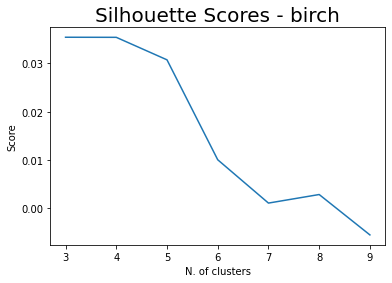

In [62]:
%matplotlib inline


plt.figure()
plt.errorbar(n_clusters, sils)
plt.title(f"Silhouette Scores - {cluster_model_name}", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.show()



## Silohuette coefficient

In [52]:
n_clusters=np.arange(3, 10)
cluster_model_name = "birch"
n_iterations = 15


sils=[]
sils_err=[]

for n in n_clusters:
    tmp_sil=[]
    for it in range(n_iterations):
        print(n, it)
        cluster_model = get_cluster_model(cluster_model_name, n, n_init=2).fit(scaled_train_features) 
        labels=cluster_model.predict(scaled_val_features)
        try:
            sil=metrics.silhouette_score(scaled_val_features, labels, metric='euclidean')
            tmp_sil.append(sil)
        except ValueError:
            print(labels)

    tmp_sil = sorted(tmp_sil)
    val=np.mean(tmp_sil[-5:])
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

3 0


UnboundLocalError: local variable 'f' referenced before assignment

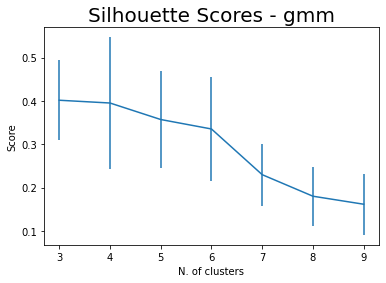

In [24]:
%matplotlib inline


plt.figure()
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title(f"Silhouette Scores - {cluster_model_name}", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.show()



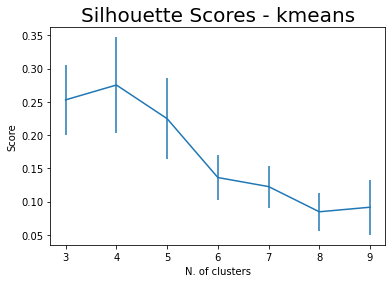

In [22]:
%matplotlib inline


plt.figure()
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title(f"Silhouette Scores - {cluster_model_name}", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.show()



## Final clustering

In [56]:
cluster_model_name = "birch"
n_clusters = 5
n_iters = 15


bst_sil=[]
models = []
mx_size = []
mn_size = []

for it in tqdm(range(n_iters)):
    cluster_model = get_cluster_model(cluster_model_name, n_clusters).fit(scaled_train_features) 
    labels = cluster_model.predict(scaled_val_features)
    unique, counts = np.unique(labels, return_counts=True)
    try:
        sil=metrics.silhouette_score(scaled_val_features, labels, metric='euclidean')
        bst_sil.append(sil)
        models.append(cluster_model)
        mx_size.append(np.max(counts)/sum(counts))
        mn_size.append(np.min(counts)/sum(counts))

    except Exception as e:
        print(e)

ind = np.argsort(bst_sil)[::-1]
print(np.array(bst_sil)[ind])
print(np.array(mx_size)[ind])
print(np.array(mn_size)[ind])


100%|██████████| 15/15 [00:18<00:00,  1.26s/it]

[0.03075417 0.03075417 0.03075417 0.03075417 0.03075417 0.03075417
 0.03075417 0.03075417 0.03075417 0.03075417 0.03075417 0.03075417
 0.03075417 0.03075417 0.03075417]
[0.36272321 0.36272321 0.36272321 0.36272321 0.36272321 0.36272321
 0.36272321 0.36272321 0.36272321 0.36272321 0.36272321 0.36272321
 0.36272321 0.36272321 0.36272321]
[0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625 0.0625
 0.0625 0.0625 0.0625 0.0625 0.0625]


AttributeError: 'AxesSubplot' object has no attribute 'ylabel'

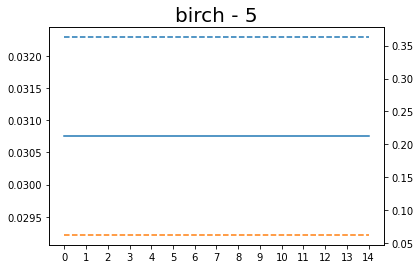

In [57]:
%matplotlib inline


plt.figure()

ax1 = plt.gca()
ax1.plot(np.array(bst_sil)[ind])

ax2 = ax1.twinx()
ax2.plot(np.array(mx_size)[ind], ls='--')
ax2.plot(np.array(mn_size)[ind], ls='--')

plt.title(f"{cluster_model_name} - {n_clusters}", fontsize=20)
plt.xticks(range(n_iters))
plt.xlabel("iterations")
ax1.set_ylabel("Silhouette Scores")
ax2.set_ylabel("proportion")
plt.show()



In [13]:
best_model = models[ind[0]]


In [57]:
scaled_train_features.shape


(2368, 2048)

In [75]:
labels_train = best_model.predict(scaled_train_features) 
labels_val = best_model.predict(scaled_val_features) 

/mnt/dataset/MoNuSeg/patches_256x256_128x128/MoNuSegTrainingData/images/TCGA-UZ-A9PN-01Z-00-DX1_031.png


In [81]:
from pathlib import Path

out_path = f"/mnt/dataset/MoNuSeg/patches_256x256_128x128/{cluster_model_name}_{n_clusters}"

if not os.path.exists(out_path):
    os.mkdir(out_path)


for l in range(n_clusters):
    if not os.path.exists(os.path.join(out_path, f"{l}")):
        os.makedirs(os.path.join(out_path, f"{l}", "MoNuSegTrainingData", "images"), exist_ok=True)
        os.makedirs(os.path.join(out_path, f"{l}", "MoNuSegTrainingData", "bin_masks"), exist_ok=True)
        os.makedirs(os.path.join(out_path, f"{l}", "MoNuSegTestData", "images"), exist_ok=True)
        os.makedirs(os.path.join(out_path, f"{l}", "MoNuSegTestData", "bin_masks"), exist_ok=True)






/mnt/dataset/MoNuSeg/patches_256x256_128x128/MoNuSegTrainingData/images/TCGA-G9-6362-01Z-00-DX1_008.png
/mnt/dataset/MoNuSeg/patches_256x256_128x128/gmm_5/1/MoNuSegTrainingData/images/TCGA-G9-6362-01Z-00-DX1_008.png
/mnt/dataset/MoNuSeg/patches_256x256_128x128/gmm_5/1/MoNuSegTrainingData/bin_masks/TCGA-G9-6362-01Z-00-DX1_008.png
/mnt/dataset/MoNuSeg/patches_256x256_128x128/MoNuSegTrainingData/images/TCGA-E2-A14V-01Z-00-DX1_009.png
/mnt/dataset/MoNuSeg/patches_256x256_128x128/gmm_5/4/MoNuSegTrainingData/images/TCGA-E2-A14V-01Z-00-DX1_009.png
/mnt/dataset/MoNuSeg/patches_256x256_128x128/gmm_5/4/MoNuSegTrainingData/bin_masks/TCGA-E2-A14V-01Z-00-DX1_009.png
/mnt/dataset/MoNuSeg/patches_256x256_128x128/MoNuSegTrainingData/images/TCGA-NH-A8F7-01A-01-TS1_036.png
/mnt/dataset/MoNuSeg/patches_256x256_128x128/gmm_5/1/MoNuSegTrainingData/images/TCGA-NH-A8F7-01A-01-TS1_036.png
/mnt/dataset/MoNuSeg/patches_256x256_128x128/gmm_5/1/MoNuSegTrainingData/bin_masks/TCGA-NH-A8F7-01A-01-TS1_036.png
/mnt/da

In [ ]:
import json



In [ ]:
train_img_dic = {}
train_mask_dic = {}

for path, label in zip(train_file_names, labels_train):
    img_path, ann_path = path[0][0], path[1][0]
    train_img_dic[img_path] = label
    train_mask_dic[ann_path] = label

out_file = os.path.join(out_path, "train.json")
with open(out_file, "w+") as f:
    json.dump({"images":train_img_dic, "bin_masks":train_mask_dic}, f)


In [ ]:
val_img_dic = {}
val_mask_dic = {}

for path, label in zip(val_file_names, labels_val):
    img_path, ann_path = path[0][0], path[1][0]
    val_img_dic[img_path] = label
    val_mask_dic[ann_path] = label

out_file = os.path.join(out_path, "val.json")
with open(out_file, "w+") as f:
    json.dump({"images":val_img_dic, "bin_masks":val_mask_dic}, f)


In [ ]:
for path, label in zip(train_file_names, labels_train):
    img_path, ann_path = path[0][0], path[1][0]
    print(img_path)
    img_dir_path = os.path.dirname(img_path)
    ann_dir_path = os.path.dirname(ann_path)
    file_name = os.path.basename(img_path)
    # file_name = Path(os.path.basename(img_path)).stem

    src = img_path
    dst = os.path.join(out_path, f"{label}", "MoNuSegTrainingData", "images", file_name)
    print(dst)
    os.symlink(src, dst)

    src = ann_path
    dst = os.path.join(out_path, f"{label}", "MoNuSegTrainingData", "bin_masks", file_name)
    print(dst)
    os.symlink(src, dst)


In [9]:
n_clusters=np.arange(2, 10)
sils=[]
sils_err=[]
iterations=15
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(scaled_features) 
        labels=gmm.predict(scaled_features)
        sil=metrics.silhouette_score(scaled_features, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

Text(0, 0.5, 'Score')

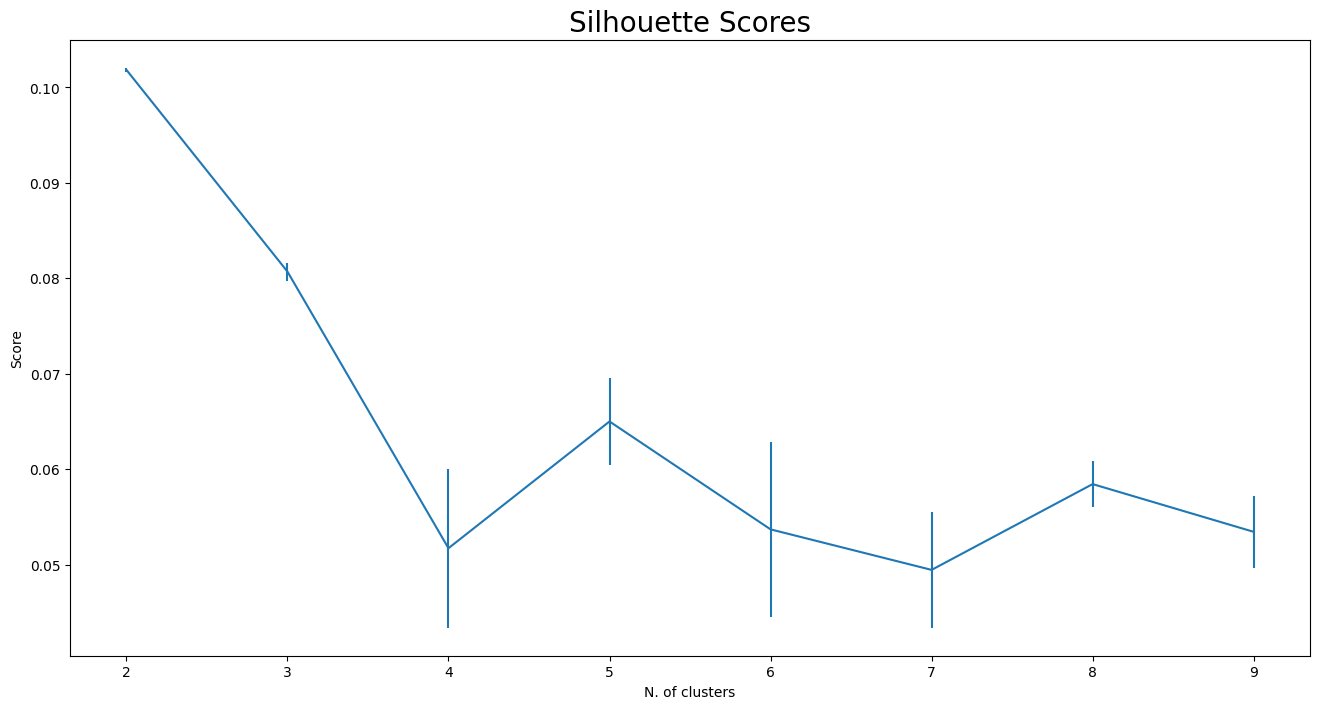

In [10]:
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

In [20]:
n_clusters=np.arange(2, 10)
sils=[]
sils_err=[]
iterations=15
for n in n_clusters:
    tmp_sil=[]
    for _ in range(iterations):
        km=KMeans(n, n_init=2).fit(scaled_features) 
        labels=km.predict(scaled_features)
        sil=metrics.silhouette_score(scaled_features, labels, metric='euclidean')
        tmp_sil.append(sil)
    val=np.mean(SelBest(np.array(tmp_sil), 5))
    err=np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)

Text(0, 0.5, 'Score')

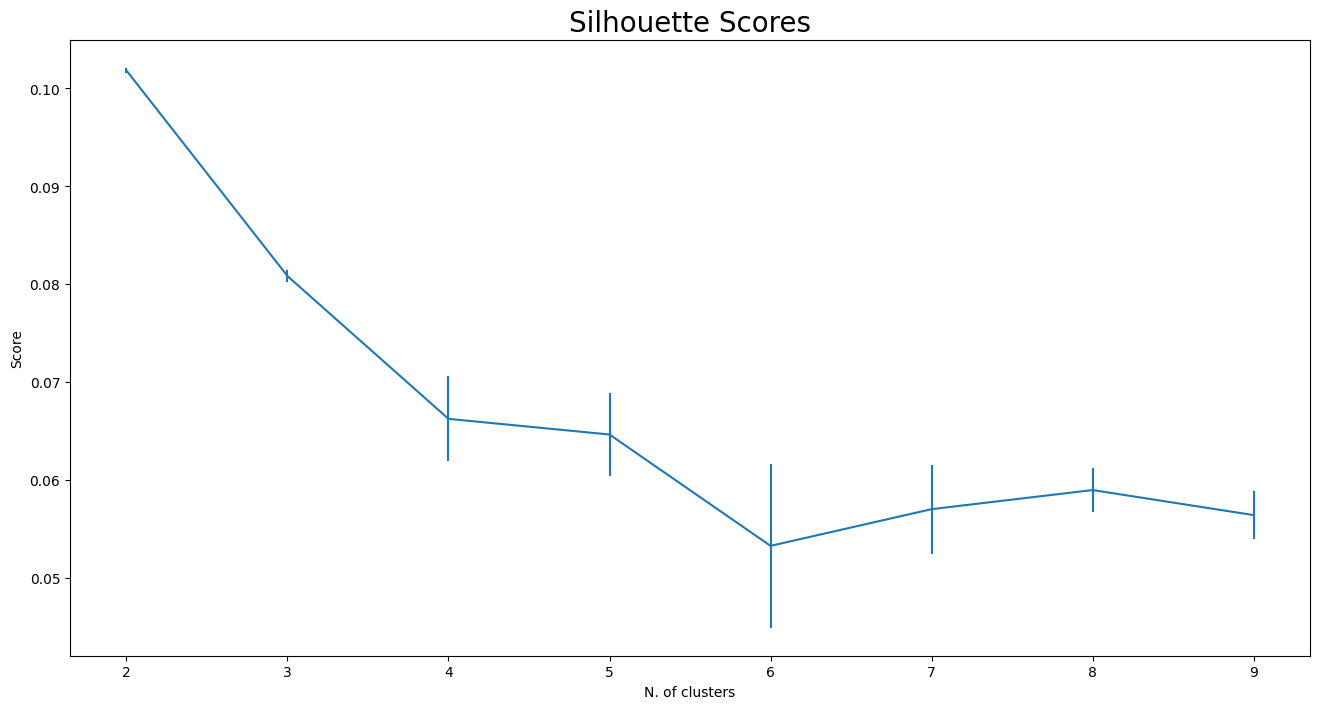

In [21]:
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

## Train - Test distance check

In [37]:
#Courtesy of https://stackoverflow.com/questions/26079881/kl-divergence-of-two-gmms. Here the difference is that we take the squared root, so it's a proper metric

def gmm_js(gmm_p, gmm_q, n_samples=10**5):
    X = gmm_p.sample(n_samples)[0]
    log_p_X = gmm_p.score_samples(X)
    log_q_X = gmm_q.score_samples(X)
    log_mix_X = np.logaddexp(log_p_X, log_q_X)

    Y = gmm_q.sample(n_samples)[0]
    log_p_Y = gmm_p.score_samples(Y)
    log_q_Y = gmm_q.score_samples(Y)
    log_mix_Y = np.logaddexp(log_p_Y, log_q_Y)

    return np.sqrt((log_p_X.mean() - (log_mix_X.mean() - np.log(2))
            + log_q_Y.mean() - (log_mix_Y.mean() - np.log(2))) / 2)

In [99]:
n_clusters=np.arange(2, 20)
iterations=20
results=[]
res_sigs=[]
for n in n_clusters:
    dist=[]
    
    for iteration in range(iterations):
        train, test=train_test_split(embeddings, test_size=0.5)
        
        gmm_train=GMM(n, n_init=2).fit(train) 
        gmm_test=GMM(n, n_init=2).fit(test) 
        dist.append(gmm_js(gmm_train, gmm_test))
    selec=SelBest(np.array(dist), int(iterations/5))
    result=np.mean(selec)
    res_sig=np.std(selec)
    results.append(result)
    res_sigs.append(res_sig)
    

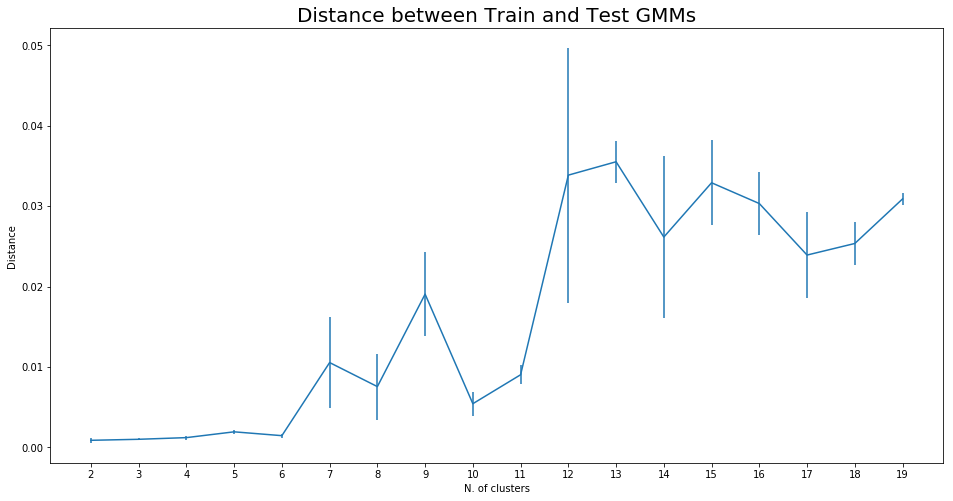

In [101]:
plt.errorbar(n_clusters, results, yerr=res_sigs)
plt.title("Distance between Train and Test GMMs", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Distance")
plt.show()

### BIC

In [103]:
n_clusters=np.arange(2, 20)
bics=[]
bics_err=[]
iterations=20
for n in n_clusters:
    tmp_bic=[]
    for _ in range(iterations):
        gmm=GMM(n, n_init=2).fit(embeddings) 
        
        tmp_bic.append(gmm.bic(embeddings))
    val=np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
    err=np.std(tmp_bic)
    bics.append(val)
    bics_err.append(err)

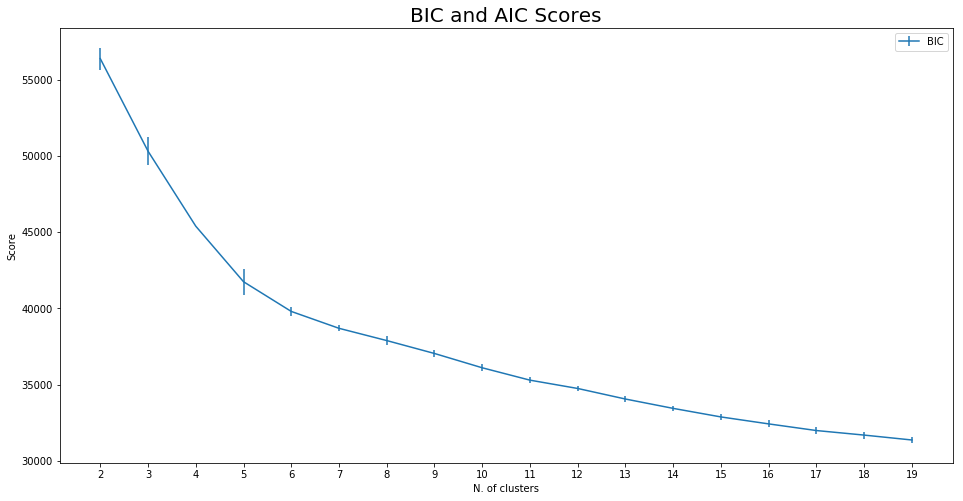

In [109]:
plt.errorbar(n_clusters,bics, yerr=bics_err, label='BIC')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

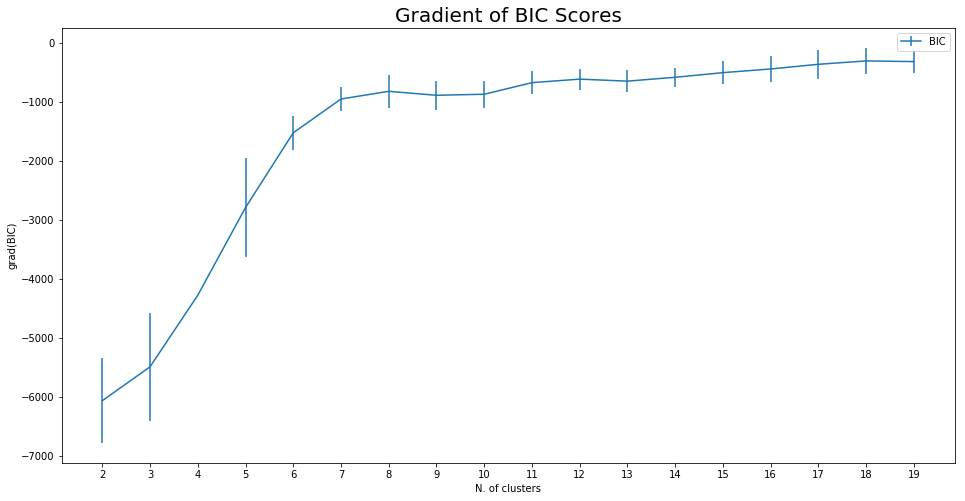

In [117]:
plt.errorbar(n_clusters, np.gradient(bics), yerr=bics_err, label='BIC')
plt.title("Gradient of BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("grad(BIC)")
plt.legend()

In [129]:
import pandas as pd
obj={'Metric': ['Silohuette score', 'Distance between Train and Test GMMs', 'Gradient of BIC scores'],
    "number of clusters": [5,6,6]}
df=pd.DataFrame(obj)
df.set_index('Metric')

,number of clusters
Metric,
Silohuette score,5
Distance between Train and Test GMMs,6
Gradient of BIC scores,6


## Cluster based on name

In [18]:
from get_embedding import get_class
import json

In [19]:
out_path = f"/mnt/dataset/MoNuSeg/patches_256x256_128x128/names_37"
if not os.path.exists(out_path): os.mkdir(out_path)

train_img_dic = {}
train_mask_dic = {}

for file_name in train_file_list:
    img_path, ann_path = file_name[0], file_name[1]
    label = get_class(img_path)

    train_img_dic[img_path] = label
    train_mask_dic[ann_path] = label

out_file = os.path.join(out_path, "train.json")
with open(out_file, "w+") as f:
    json.dump({"images":train_img_dic, "bin_masks":train_mask_dic}, f)



In [20]:
out_path = f"/mnt/dataset/MoNuSeg/patches_256x256_128x128/names_37"
if not os.path.exists(out_path): os.mkdir(out_path)

val_img_dic = {}
val_mask_dic = {}

for file_name in valid_file_list:
    img_path, ann_path = file_name[0], file_name[1]
    label = get_class(img_path)

    val_img_dic[img_path] = label
    val_mask_dic[ann_path] = label

out_file = os.path.join(out_path, "valid.json")
with open(out_file, "w+") as f:
    json.dump({"images":val_img_dic, "bin_masks":val_mask_dic}, f)



In [46]:
js_name = "/mnt/dataset/MoNuSeg/patches_256x256_128x128/names_37_14/train.json"
out_path = "/mnt/dataset/MoNuSeg/patches_256x256_128x128/names_37_14"

par_dir = "MoNuSegTrainingData"
remove_existing = True

with open(js_name, "r") as f:
    js = json.load(f)
    print(js)

    for path, label in js['images'].items():

        if not os.path.exists(os.path.join(out_path, label)):
            os.makedirs(os.path.join(out_path, f"{label}", par_dir, "images"))
            os.makedirs(os.path.join(out_path, f"{label}", par_dir, "bin_masks"))            

        file_name = os.path.basename(path)
        # file_name = Path(os.path.basename(img_path)).stem

        src = path
        dst = os.path.join(out_path, f"{label}", par_dir, "images", file_name)
        print(src, dst)
        if not os.path.exists(dst):
            os.symlink(src, dst)
        elif remove_existing:
            os.unlink(dst)
            os.symlink(src, dst)
        else:
            raise ValueError(f"path {dst} already exists")


    for path, label in js['bin_masks'].items():

        if not os.path.exists(os.path.join(out_path, label)):
            os.makedirs(os.path.join(out_path, f"{label}", par_dir, "images"))
            os.makedirs(os.path.join(out_path, f"{label}", par_dir, "bin_masks"))            

        file_name = os.path.basename(path)
        # file_name = Path(os.path.basename(img_path)).stem

        src = path
        dst = os.path.join(out_path, f"{label}", par_dir, "bin_masks", file_name)
        print(src, dst)
        if not os.path.exists(dst):
            os.symlink(src, dst)
        elif remove_existing:
            os.unlink(dst)
            os.symlink(src, dst)
        else:
            raise ValueError(f"path {dst} already exists")
        
        break




{'images': {'/mnt/dataset/MoNuSeg/patches_256x256_128x128/MoNuSegTrainingData/images/TCGA-18-5592-01Z-00-DX1_000.png': 'TCGA-18-5592-01Z-00-DX1', '/mnt/dataset/MoNuSeg/patches_256x256_128x128/MoNuSegTrainingData/images/TCGA-18-5592-01Z-00-DX1_001.png': 'TCGA-18-5592-01Z-00-DX1', '/mnt/dataset/MoNuSeg/patches_256x256_128x128/MoNuSegTrainingData/images/TCGA-18-5592-01Z-00-DX1_002.png': 'TCGA-18-5592-01Z-00-DX1', '/mnt/dataset/MoNuSeg/patches_256x256_128x128/MoNuSegTrainingData/images/TCGA-18-5592-01Z-00-DX1_003.png': 'TCGA-18-5592-01Z-00-DX1', '/mnt/dataset/MoNuSeg/patches_256x256_128x128/MoNuSegTrainingData/images/TCGA-18-5592-01Z-00-DX1_004.png': 'TCGA-18-5592-01Z-00-DX1', '/mnt/dataset/MoNuSeg/patches_256x256_128x128/MoNuSegTrainingData/images/TCGA-18-5592-01Z-00-DX1_005.png': 'TCGA-18-5592-01Z-00-DX1', '/mnt/dataset/MoNuSeg/patches_256x256_128x128/MoNuSegTrainingData/images/TCGA-18-5592-01Z-00-DX1_006.png': 'TCGA-18-5592-01Z-00-DX1', '/mnt/dataset/MoNuSeg/patches_256x256_128x128/MoNu

In [38]:
%load_ext autoreload
%autoreload 2

from misc.cluster import json_to_symlink


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [43]:
js_name = "/mnt/dataset/MoNuSeg/patches_256x256_128x128/names_37_14/train.json"
out_path = "/mnt/dataset/MoNuSeg/patches_256x256_128x128/names_37_14"

par_dir = "MoNuSegTrainingData"


json_to_symlink(js_name, out_path, par_dir, remove_existing=True)

In [44]:
js_name = "/mnt/dataset/MoNuSeg/patches_256x256_128x128/names_37_14/valid.json"
out_path = "/mnt/dataset/MoNuSeg/patches_256x256_128x128/names_37_14"

par_dir = "MoNuSegTestData"


json_to_symlink(js_name, out_path, par_dir)

ValueError: path /mnt/dataset/MoNuSeg/patches_256x256_128x128/names_37_14/TCGA-2Z-A9J9-01A-01-TS1/MoNuSegTestData/bin_masks/TCGA-2Z-A9J9-01A-01-TS1_000.png already exists

In [14]:
for file_name in train_file_names:
    img_path, ann_path = file_name[0], file_name[1]
    label = get_class(img_path)


/mnt/dataset/MoNuSeg/patches_256x256_128x128/MoNuSegTrainingData/images/TCGA-UZ-A9PN-01Z-00-DX1_011.png TCGA-UZ-A9PN-01Z-00-DX1
